# Driveway Footprint Detection 
Notebook 1

In [6]:
import os
os.environ['OPENCV_IO_ENABLE_JASPER']='True' # reading jp2000 images
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio as rio
from rasterio.windows import Window
import random
from sklearn.metrics import confusion_matrix
from utils import loss, util

import torch
import torch.nn as nn
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import transforms
import csv
import PIL
from tqdm import tqdm
import pandas as pd
import os
import torch
import cv2
import rasterio as rio
import random
from rasterio.windows import Window

import numpy as np

## Data exploration

In [2]:
# city = 'kw'
# crop_size = 512
# EXPERIMENT_NAME = 'test2'
# TOTAL_EPOCHS = 500
# LR = 1e-4
# WD = 5e-4
# test_freq = 5

### Data split
Train 70%
Validation 15%
Test 15%

### Dataloaders

In [3]:
class TrainDrivewayDataset(Dataset):
    def __init__(self, config):
        
        self.config = config
        self.df_train = pd.read_csv(os.path.join(self.config['data_dir'], 'train.csv'))
        
        self.crop_size = self.config['train']['crop_size']
        self.reshape = self.config['train']['reshape']
        self.reshape_size = self.config['train']['reshape_size']
        self.crop_diff = self.config['train']['crop_diff']
        
        self.to_pil = transforms.ToPILImage()
        self.color_jit = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.05)
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return(len(self.df_train))
        
    def __getitem__(self, index):
                
        # prepapre reading paths
        path_img = self.df_train.iloc[index]['path_img']
        path_building = self.df_train.iloc[index]['path_building_fp']
        path_road = self.df_train.iloc[index]['path_road_mask']
        path_driveway = self.df_train.iloc[index]['path_driveway_mask']
        
        # read src datasets
        src_img = rio.open(path_img, mode = 'r')
        src_building = rio.open(path_building, mode ='r')
        src_road = rio.open(path_road, mode = 'r')
        src_driveway = rio.open(path_driveway, mode = 'r')
        
        meta = src_img.meta
        x_lim = meta['width'] - self.crop_size + np.random.randint(-(self.crop_diff), self.crop_diff)
        y_lim = meta['height'] - self.crop_size + np.random.randint(-(self.crop_diff), self.crop_diff)

        col_off = np.random.randint(0, x_lim)
        row_off = np.random.randint(0, y_lim)

        window = Window(col_off=col_off,
            row_off=row_off,
            width=self.crop_size,
            height=self.crop_size)

        _mask = src_driveway.read(window = window)
        
                
        # read images, if you get nullpointer error in img read, there is a channel issue. Reformat the images.
        _img = src_img.read((1,2,3), window = window)
        _mask_building = src_building.read(1, window = window)
        _mask_road = src_road.read(1, window = window)
        _mask_driveway = src_driveway.read(1, window = window)
        
        _input_tensor, _mask = self.transform(_img, _mask_building, _mask_road, _mask_driveway)
        
        return _input_tensor, _mask
        
    def transform(self, img, mask_building, mask_road, mask_driveway):
        """
        Input Tensor, Ouput Tensor
        
        """
        
        # To Tensor
        img = torch.tensor(img)
        mask_building = torch.tensor(mask_building)
        mask_road = torch.tensor(mask_road)
        mask_driveway = torch.tensor(mask_driveway)
        
        # To PIL image
        image = self.to_pil(img)
        mask_building = self.to_pil(mask_building)
        mask_road = self.to_pil(mask_road)
        mask_driveway = self.to_pil(mask_driveway)
        
        # Resize
        image = TF.resize(image, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_building = TF.resize(mask_building, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_road = TF.resize(mask_road, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_driveway = TF.resize(mask_driveway, size = self.reshape_size, interpolation=PIL.Image.NEAREST)

        # Random horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask_building= TF.hflip(mask_building)
            mask_road= TF.hflip(mask_road)
            mask_driveway= TF.hflip(mask_driveway)
            
        # Random Vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask_building = TF.vflip(mask_building)
            mask_road = TF.vflip(mask_road)
            mask_driveway = TF.vflip(mask_driveway)
        
        # Color Jitter Image
        image = self.color_jit(image)
        
        # Change to tensors
        image = self.to_tensor(image)
        mask_building = self.to_tensor(mask_building)
        mask_road = self.to_tensor(mask_road)
        mask_driveway = self.to_tensor(mask_driveway)
        
        # Merge input tensors to 5 channel, 3 image 1 building 1 road
        _input_stacked = torch.cat((image, mask_building, mask_road))
        
        return _input_stacked, mask_driveway

In [4]:
class ValDrivewayDataset(Dataset):
    def __init__(self, config):
        
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config['data_dir'], 'val.csv'))
        
        self.crop_size = self.config['val']['crop_size']
        self.reshape = self.config['val']['reshape']
        self.reshape_size = self.config['val']['reshape_size']
        self.crop_diff = self.config['val']['crop_diff']
        
        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return(len(self.df))
        
    def __getitem__(self, index):
                
        # prepapre reading paths
        path_img = self.df.iloc[index]['path_img']
        path_building = self.df.iloc[index]['path_building_fp']
        path_road = self.df.iloc[index]['path_road_mask']
        path_driveway = self.df.iloc[index]['path_driveway_mask']
        
        # read src datasets
        src_img = rio.open(path_img, mode = 'r')
        src_building = rio.open(path_building, mode ='r')
        src_road = rio.open(path_road, mode = 'r')
        src_driveway = rio.open(path_driveway, mode = 'r')
        
        meta = src_img.meta
        x_lim = meta['width'] - self.crop_size
        y_lim = meta['height'] - self.crop_size

        col_off = np.random.randint(0, x_lim)
        row_off = np.random.randint(0, y_lim)

        window = Window(col_off=col_off,
            row_off=row_off,
            width=self.crop_size,
            height=self.crop_size)

        _mask = src_driveway.read(window = window)
        
                
        # read images, if you get nullpointer error in img read, there is a channel issue. Reformat the images.
        _img = src_img.read((1,2,3), window = window)
        _mask_building = src_building.read(1, window = window)
        _mask_road = src_road.read(1, window = window)
        _mask_driveway = src_driveway.read(1, window = window)
        
        _input_tensor, _mask = self.transform(_img, _mask_building, _mask_road, _mask_driveway)
        
        return _input_tensor, _mask
        
    def transform(self, img, mask_building, mask_road, mask_driveway):
        """
        Input Tensor, Ouput Tensor
        
        """
        
        # To Tensor
        img = torch.tensor(img)
        mask_building = torch.tensor(mask_building)
        mask_road = torch.tensor(mask_road)
        mask_driveway = torch.tensor(mask_driveway)
        
        # To PIL image
        image = self.to_pil(img)
        mask_building = self.to_pil(mask_building)
        mask_road = self.to_pil(mask_road)
        mask_driveway = self.to_pil(mask_driveway)
        
        # Resize
        image = TF.resize(image, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_building = TF.resize(mask_building, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_road = TF.resize(mask_road, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_driveway = TF.resize(mask_driveway, size = self.reshape_size, interpolation=PIL.Image.NEAREST)

        # Random horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask_building= TF.hflip(mask_building)
            mask_road= TF.hflip(mask_road)
            mask_driveway= TF.hflip(mask_driveway)
            
        # Random Vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask_building = TF.vflip(mask_building)
            mask_road = TF.vflip(mask_road)
            mask_driveway = TF.vflip(mask_driveway)
        
        # Change to tensors
        image = self.to_tensor(image)
        mask_building = self.to_tensor(mask_building)
        mask_road = self.to_tensor(mask_road)
        mask_driveway = self.to_tensor(mask_driveway)
        
        # Merge input tensors to 5 channel, 3 image 1 building 1 road
        _input_stacked = torch.cat((image, mask_building, mask_road))
        
        return _input_stacked, mask_driveway

### Config

In [5]:
config = {
    "data_dir": "./data/data_2",
    "train": {
        "crop_size": 1250,
        "reshape": True,
        "reshape_size": 512,
        "crop_diff": 100
    },
    "val": {
        "crop_size": 1250,
        "reshape": True,
        "reshape_size": 512,
        "crop_diff": 0
    },
    "train_batch_size": 16,
    "val_batch_size": 8,
    "epochs": 1000,
    "test_freq": 10,
    "lr": 1e-4,
    "lr_wd": 1e-4,
    "exp_name": "exp_1",
    "num_workers": 24
}

In [6]:
experiment_dir = f"experiments/{config['exp_name']}"

### Prepare DeepLabV3 segmentation model

In [7]:
import torchvision
import torchvision.models as models

In [8]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=1, aux_loss=None)

In [9]:
model.backbone.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

### Initilize dataloaders

In [10]:
df_train = pd.read_csv(os.path.join(config['data_dir'], 'train.csv'))

train_sample_weights = df_train.probability.tolist()
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weights, len(train_sample_weights))

train_dataset = TrainDrivewayDataset(config)
train_loader = DataLoader(train_dataset, batch_size=config["train_batch_size"], 
                          num_workers=config['num_workers'], sampler=train_sampler)

In [11]:
df_val = pd.read_csv(os.path.join(config['data_dir'], 'val.csv'))

val_sample_weights = df_val.probability.tolist()
val_sampler = torch.utils.data.sampler.WeightedRandomSampler(val_sample_weights, len(val_sample_weights))

val_dataset = ValDrivewayDataset(config = config)
val_loader = DataLoader(val_dataset, batch_size=config["val_batch_size"], 
                        num_workers=config['num_workers'], sampler=val_sampler)

In [12]:
# train_ds = TrainDrivewayDataset(config)
# train_loader = DataLoader(train_ds, batch_size = config['train_batch_size'], shuffle = True, num_workers = config['num_workers'])

# val_ds = ValTestDrivewayDataset(config)
# val_loader = DataLoader(val_ds, batch_size = config['val_batch_size'], shuffle = True, num_workers = config['num_workers'])

### Imports

In [13]:
from utils import loss, util
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F

### Loss

In [14]:
def dice_loss(y_true, y_pred, smooth = 1e-6):
    pred = y_pred.contiguous()
    target = y_true.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, weight_bce):
    pred = pred
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(y_true = target, y_pred = pred)

    loss = bce * weight_bce + dice * (1-weight_bce)

    return loss

def compute_miou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    
    return np.mean(IoU)

### Logging

In [15]:
if not os.path.isdir(experiment_dir):
    os.makedirs(experiment_dir)

In [16]:
### Logging Files
train_file = "{}/{}_train_loss.txt".format(experiment_dir, config['exp_name'])
test_file = "{}/{}_test_loss.txt".format(experiment_dir, config['exp_name'])

train_loss_file = open(train_file, "w")
val_loss_file = open(test_file, "w")

In [17]:
num_gpus = torch.cuda.device_count()

In [18]:
if num_gpus > 1:
    print("Training with multiple GPUs ({})".format(num_gpus))
    model = nn.DataParallel(model).cuda()
elif num_gpus == 1:
    print("Single Cuda Node is avaiable")
    model.cuda()
else:
    print("Training on CPU, GPU not available")

Training with multiple GPUs (4)


## DO CHECK HERE

In [19]:
best_miou = 0
best_loss = 1e10
epochs = 1
total_epochs = config['epochs']

In [20]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = config['lr'],
    weight_decay = config['lr_wd']
)

In [22]:
def train(epochs):    
    model.train()
    
    for i, sample in enumerate(train_loader):
        optimizer.zero_grad()
        
        _input, gt = sample
        _output = model(_input.cuda())
        
        loss = calc_loss(_output['out'].cpu(), gt, weight_bce=0.5)
        
        loss.backward()
        optimizer.step()
        
        pred = (torch.sigmoid(_output['out'].cpu()) > 0.5).numpy().astype(int)
        
        gt = gt.cpu().numpy().astype(int)
        running_mIOU = compute_miou(y_pred=pred, y_true=gt)
        
        print('Train Epoch:{} --- Running Loss:{} --- Running mIOU:{}'.format(epochs, loss.item(), running_mIOU))

In [23]:
def save_checkpoint(loss, model, optimizer, experiment_dir):

    if torch.cuda.device_count() > 1:
        arch = type(model.module).__name__
    else:
        arch = type(model).__name__
    state = {
        "arch": arch,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": loss,
    }
    filename = os.path.join(
        experiment_dir, "checkpoint-loss-{:.4f}.pth.tar".format(loss)
    )
    torch.save(state, filename)
    os.rename(filename, os.path.join(experiment_dir, "model_best.pth.tar"))
    print("Saving current best: {} ...".format("model_best.pth.tar"))

In [24]:
def val():
    with torch.no_grad():
        val_loss = 0
        
        model.eval()

        for i, sample in enumerate(val_loader):
            _input, gt = sample
            _output = model(_input.cuda())

            loss = calc_loss(_output['out'].cpu(), gt, weight_bce=0.5)

            pred = (torch.sigmoid(_output['out'].cpu()) > 0.5).numpy().astype(int)
            
            gt = gt.cpu().numpy().astype(int)
            running_mIOU = compute_miou(y_pred=pred, y_true=gt)

            print('Running Loss:{} --- Running mIOU:{}'.format(loss.item(), running_mIOU))
            
            val_loss = val_loss + loss
        
        return val_loss

In [28]:
test_freq = config['test_freq']

while epochs < total_epochs:
    train(epochs)
    
    if epochs%test_freq == 0:
        val_loss = val()
        
        if val_loss < best_loss:
            best_loss = val_loss
            save_checkpoint(loss = best_loss, 
                            model = model, 
                            optimizer = optimizer, 
                            experiment_dir = experiment_dir)
    epochs = epochs + 1

Train Epoch:1 --- Running Loss:0.7261912226676941 --- Running mIOU:0.49573213639735325
Train Epoch:1 --- Running Loss:0.7074239253997803 --- Running mIOU:0.5153619074690174
Train Epoch:1 --- Running Loss:0.6809643507003784 --- Running mIOU:0.531050895711434
Train Epoch:1 --- Running Loss:0.6911866664886475 --- Running mIOU:0.5256030367646344
Train Epoch:1 --- Running Loss:0.6865183115005493 --- Running mIOU:0.5315358428599826
Train Epoch:1 --- Running Loss:0.6917109489440918 --- Running mIOU:0.5226575465420009
Train Epoch:1 --- Running Loss:0.6836482286453247 --- Running mIOU:0.5239766779450157
Train Epoch:1 --- Running Loss:0.6660503149032593 --- Running mIOU:0.5484286753767497
Train Epoch:1 --- Running Loss:0.671397864818573 --- Running mIOU:0.5444766011751683
Train Epoch:1 --- Running Loss:0.6419479250907898 --- Running mIOU:0.5921088562402128
Train Epoch:2 --- Running Loss:0.6404526233673096 --- Running mIOU:0.5650835296852859
Train Epoch:2 --- Running Loss:0.6163062453269958 --- R

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


Train Epoch:141 --- Running Loss:0.23935192823410034 --- Running mIOU:0.8520642347621932
Train Epoch:141 --- Running Loss:0.2755114734172821 --- Running mIOU:0.8444256771692802
Train Epoch:141 --- Running Loss:0.2453598976135254 --- Running mIOU:0.8467429150823642
Train Epoch:141 --- Running Loss:0.231313556432724 --- Running mIOU:0.8562139781109204
Train Epoch:141 --- Running Loss:0.22949467599391937 --- Running mIOU:0.8169423909603252
Train Epoch:141 --- Running Loss:0.2483333796262741 --- Running mIOU:0.8411076215446694
Train Epoch:141 --- Running Loss:0.20462048053741455 --- Running mIOU:0.8367348692349212
Train Epoch:141 --- Running Loss:0.27110156416893005 --- Running mIOU:0.8604608673063976
Train Epoch:141 --- Running Loss:0.2446337193250656 --- Running mIOU:0.8688765719527702
Train Epoch:141 --- Running Loss:0.3511269986629486 --- Running mIOU:0.7945485317318801
Train Epoch:142 --- Running Loss:0.23583245277404785 --- Running mIOU:0.8283366981289177
Train Epoch:142 --- Running 

In [10]:
for i, sample in enumerate(val_loader):
    _input, gt = sample
    _output = model(_input.cuda())

NameError: name 'val_loader' is not defined

In [30]:
pred = (torch.sigmoid(_output['out'].cpu()) > 0.5).numpy().astype(int)

In [7]:
idxx = 2

In [8]:
plt.imshow(_input[idxx][:3].cpu().numpy().transpose(1,2,0))

NameError: name '_input' is not defined

In [9]:
plt.imshow(_input[idxx][3:4].squeeze())

NameError: name '_input' is not defined

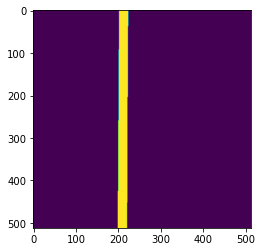

In [62]:
plt.imshow(_input[idxx][4:5].squeeze())

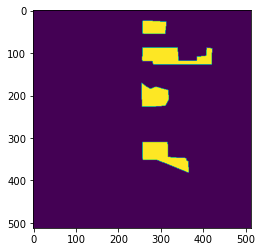

In [63]:
plt.imshow(gt[idxx].squeeze())

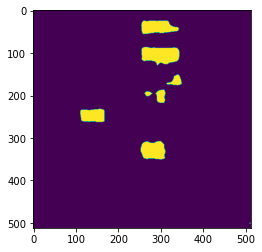

In [64]:
plt.imshow(pred[idxx].squeeze())

In [ ]:
class ValTestDrivewayDataset(Dataset):
    def __init__(self, path_directory, mode):
        self.path_directory = path_directory
        
        self.namefile = open(os.path.join(self.path_directory, (mode + '.txt')), 'r')
        self.reader = csv.reader(self.namefile)
        self.image_names = [row[0] for row in self.reader]
        
        self.crop_size = 768
        self.reshape = True
        self.reshape_size = 512
        
        self.to_pil = transforms.ToPILImage()
#         self.color_jit = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.05)
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return(len(self.image_names))
        
    def __getitem__(self, index):
        # randomly choose an image
        file_name = random.choice(self.image_names)
        
        # prepapre reading paths
        path_img = os.path.join('/mnt/mount-point-directory/datasets/', city, 'VRT')
        path_building = os.path.join(self.path_directory, 'data', 'building_polygon', 'tiles_jp2')
        path_road = os.path.join(self.path_directory, 'data', 'road_fill', 'tiles_jp2')
        path_driveway = os.path.join(self.path_directory, 'data', 'driveways_polygon', 'tiles_jp2')
        
        # read src datasets
        src_img = rio.open(os.path.join(path_img, file_name), mode = 'r')
        src_building = rio.open(os.path.join(path_building, file_name), mode ='r')
        src_road = rio.open(os.path.join(path_road, file_name), mode = 'r')
        src_driveway = rio.open(os.path.join(path_driveway, file_name), mode = 'r')
        
        meta = src_img.meta

        _mask = src_driveway.read()
        
                
        # read images, if you get nullpointer error in img read, there is a channel issue. Reformat the images.
        _img = src_img.read((1,2,3), window = window)
        _mask_building = src_building.read(1, window = window)
        _mask_road = src_road.read(1, window = window)
        _mask_driveway = src_driveway.read(1, window = window)
        
        _input_tensor, _mask = self.transform(_img, _mask_building, _mask_road, _mask_driveway)
        
        return _input_tensor, _mask
        
    def transform(self, img, mask_building, mask_road, mask_driveway):
        """
        Input Tensor, Ouput Tensor
        
        """
        
        # To Tensor
        img = torch.tensor(img)
        mask_building = torch.tensor(mask_building)
        mask_road = torch.tensor(mask_road)
        mask_driveway = torch.tensor(mask_driveway)
        
        # To PIL image
        image = self.to_pil(img)
        mask_building = self.to_pil(mask_building)
        mask_road = self.to_pil(mask_road)
        mask_driveway = self.to_pil(mask_driveway)
        
        # Resize
        image = TF.resize(image, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_building = TF.resize(mask_building, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_road = TF.resize(mask_road, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_driveway = TF.resize(mask_driveway, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        
        # Change to tensors
        image = self.to_tensor(image)
        mask_building = self.to_tensor(mask_building)
        mask_road = self.to_tensor(mask_road)
        mask_driveway = self.to_tensor(mask_driveway)
        
        # Merge input tensors to 5 channel, 3 image 1 building 1 road
        _input_stacked = torch.cat((image, mask_building, mask_road))
        
        return _input_stacked, mask_driveway